In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-19 00:28:23.028167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 00:28:23.028194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by week

In [3]:
df = pd.read_csv('consumos_cst.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('cst').resample('W').sum()

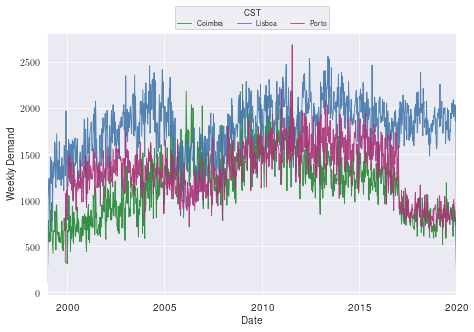

In [4]:
df.pivot_table(values="nr",index="date",columns="cst").plot(figsize=(17*cm,12*cm), linewidth=0.9, alpha=0.9, color=[colors[2], colors[0], colors[5]], xlabel='Date', ylabel='Weekly Demand')
plt.legend(['Coimbra', 'Lisboa', 'Porto'], title_fontsize='small', fontsize='x-small', title='CST', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/demand_weekly_cst.pdf', bbox_inches = "tight")

### Create batches of training data (12 weeks)

In [5]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [6]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=100)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [7]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 24, 8, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [8]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [9]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [10]:
df1 = df.pivot_table('nr', 'date', 'cst')
df1['Total'] = df1.sum(axis=1)
df1 = df1.fillna(0)

In [11]:
len(df1)

1097

In [12]:
dataset = df1[['Coimbra', 'Lisboa', 'Porto']].values
dataset = df1[['Coimbra', 'Lisboa', 'Porto']].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae, rmse, smape = train_predict(dataset[:953], dataset_total[:953], dataset[953:], df1[['Total']][953:].values)

2022-10-19 00:28:26.524983: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 00:28:26.525015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-19 00:28:26.525371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
29/29 [==============================] - 2s 36ms/step - loss: 0.6013
Epoch 2/500
29/29 [==============================] - 1s 31ms/step - loss: 0.3108
Epoch 3/500
29/29 [==============================] - 1s 31ms/step - loss: 0.1123
Epoch 4/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0618
Epoch 5/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0586
Epoch 6/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0576
Epoch 7/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0568
Epoch 8/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0566
Epoch 9/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0568
Epoch 10/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0568
Epoch 11/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0566
Epoch 12/500
29/29 [==============================] - 1s 34ms/step - loss: 0.0571
Epoch 13/500
29/29 [=====

29/29 [==============================] - 1s 34ms/step - loss: 0.0548
Epoch 102/500
29/29 [==============================] - 1s 48ms/step - loss: 0.0551
Epoch 103/500
29/29 [==============================] - 1s 45ms/step - loss: 0.0567
Epoch 104/500
29/29 [==============================] - 1s 34ms/step - loss: 0.0549
Epoch 105/500
29/29 [==============================] - 1s 44ms/step - loss: 0.0554
Epoch 106/500
29/29 [==============================] - 1s 33ms/step - loss: 0.0558
Epoch 107/500
29/29 [==============================] - 1s 36ms/step - loss: 0.0551
Epoch 108/500
29/29 [==============================] - 1s 35ms/step - loss: 0.0548
Epoch 109/500
29/29 [==============================] - 1s 46ms/step - loss: 0.0553
Epoch 110/500
29/29 [==============================] - 1s 33ms/step - loss: 0.0555
Epoch 111/500
29/29 [==============================] - 1s 43ms/step - loss: 0.0554
Epoch 112/500
29/29 [==============================] - 1s 35ms/step - loss: 0.0546
Epoch 113/500
29/2

29/29 [==============================] - 2s 54ms/step - loss: 0.0535
Epoch 200/500
29/29 [==============================] - 1s 49ms/step - loss: 0.0538
Epoch 201/500
29/29 [==============================] - 2s 59ms/step - loss: 0.0537
Epoch 202/500
29/29 [==============================] - 2s 55ms/step - loss: 0.0538
Epoch 203/500
29/29 [==============================] - 2s 53ms/step - loss: 0.0534
Epoch 204/500
29/29 [==============================] - 1s 44ms/step - loss: 0.0537
Epoch 205/500
29/29 [==============================] - 1s 45ms/step - loss: 0.0536
Epoch 206/500
29/29 [==============================] - 1s 45ms/step - loss: 0.0540
Epoch 207/500
29/29 [==============================] - 1s 46ms/step - loss: 0.0540
Epoch 208/500
29/29 [==============================] - 1s 45ms/step - loss: 0.0532
Epoch 209/500
29/29 [==============================] - 1s 47ms/step - loss: 0.0535
Epoch 210/500
29/29 [==============================] - 1s 46ms/step - loss: 0.0535
Epoch 211/500
29/2

29/29 [==============================] - 2s 55ms/step - loss: 0.0520
Epoch 298/500
29/29 [==============================] - 2s 54ms/step - loss: 0.0523
Epoch 299/500
29/29 [==============================] - 2s 54ms/step - loss: 0.0522
Epoch 300/500
29/29 [==============================] - 2s 54ms/step - loss: 0.0524
Epoch 301/500
29/29 [==============================] - 2s 55ms/step - loss: 0.0520
Epoch 302/500
29/29 [==============================] - 2s 52ms/step - loss: 0.0522
Epoch 303/500
29/29 [==============================] - 1s 52ms/step - loss: 0.0527
Epoch 304/500
29/29 [==============================] - 2s 54ms/step - loss: 0.0522
Epoch 305/500
29/29 [==============================] - 2s 60ms/step - loss: 0.0524
Epoch 306/500
29/29 [==============================] - 1s 51ms/step - loss: 0.0526
Epoch 307/500
29/29 [==============================] - 1s 50ms/step - loss: 0.0523
Epoch 308/500
29/29 [==============================] - 2s 56ms/step - loss: 0.0521
Epoch 309/500
29/2

29/29 [==============================] - 1s 31ms/step - loss: 0.0511
Epoch 396/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0511
Epoch 397/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0515
Epoch 398/500
29/29 [==============================] - 1s 32ms/step - loss: 0.0514
Epoch 399/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0510
Epoch 400/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0511
Epoch 401/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0513
Epoch 402/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0511
Epoch 403/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0509
Epoch 404/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0509
Epoch 405/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0508
Epoch 406/500
29/29 [==============================] - 1s 31ms/step - loss: 0.0510
Epoch 407/500
29/2

29/29 [==============================] - 2s 56ms/step - loss: 0.0506
Epoch 494/500
29/29 [==============================] - 1s 36ms/step - loss: 0.0504
Epoch 495/500
29/29 [==============================] - 1s 45ms/step - loss: 0.0503
Epoch 496/500
29/29 [==============================] - 1s 36ms/step - loss: 0.0500
Epoch 497/500
29/29 [==============================] - 1s 35ms/step - loss: 0.0503
Epoch 498/500
29/29 [==============================] - 1s 39ms/step - loss: 0.0506
Epoch 499/500
29/29 [==============================] - 1s 39ms/step - loss: 0.0503
Epoch 500/500
29/29 [==============================] - 1s 36ms/step - loss: 0.0502
[[3488.]
 [3541.]
 [3312.]
 [3345.]
 [3397.]
 [3138.]
 [3227.]
 [3341.]] [[3600.072 ]
 [3614.0823]
 [3640.3833]
 [3559.9695]
 [3558.634 ]
 [3605.835 ]
 [3624.2007]
 [3608.4058]] 24 32
[[3913.]
 [3690.]
 [3758.]
 [3644.]
 [4069.]
 [3832.]
 [3041.]
 [3428.]] [[3335.648 ]
 [3380.9832]
 [3419.945 ]
 [3365.277 ]
 [3366.0361]
 [3389.991 ]
 [3396.6401]
 [

In [13]:
len(smape)

15

### Calculate Error

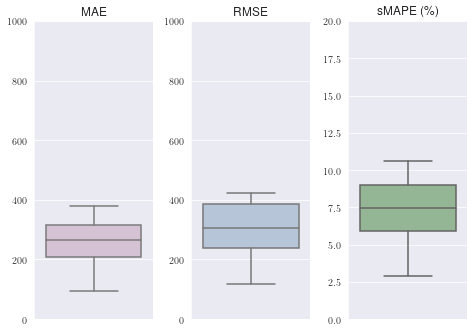

In [14]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 1000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 1000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 20))
plt.tight_layout()
#plt.savefig('figures/demand_lstm_weekly_cst_boxplot.pdf')

In [16]:
demand_lstm_week_cst = [mae,rmse,smape]
%store demand_lstm_week_cst

Stored 'demand_lstm_week_cst' (list)
